# Lab 1: Variance of Sample Means and Correlation

Welcome to Lab 1 and Data 8.3x!

In this week's lab, we will cover two relatively orthogonal concepts. First, we will investigate the variance of sample means, found in [Section 14.5](https://www.inferentialthinking.com/chapters/14/5/Variability_of_the_Sample_Mean) of our textbook. We will also get some hands-on practice with understanding the association between two variables, which you can read more about in [Section 15.1](https://www.inferentialthinking.com/chapters/15/1/Correlation).

In [1]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)



## 1. How Faithful is Old Faithful? 

(Note: clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

Some of Old Faithful's eruptions last longer than others.  When it has a long eruption, there's generally a longer wait until the next eruption.

If you visit Yellowstone, you might want to predict when the next eruption will happen, so you can see the rest of the park and come to see the geyser when it erupts.  To predict one variable from another, the first step is to understand the association between them.

The dataset has one row for each observed eruption.  It includes the following columns:
- **duration**: Eruption duration, in minutes
- **wait**: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [3]:
faithful = Table.read_table("faithful.csv")
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


** Question 1.1 **
<br/>
Make a scatter plot of the data.  It's conventional to put the column we will try to predict on the vertical axis and the other column on the horizontal axis.

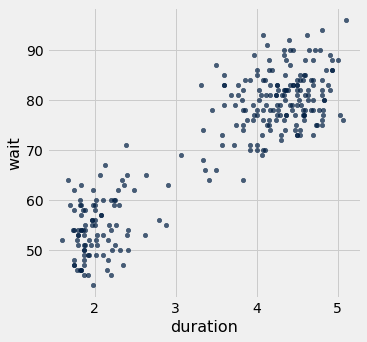

In [6]:
faithful.scatter('duration')

Look at the scatter plot. Does the association between wait times and eruption durations appear to be linear? 

There's more going on than just a linear association. The eruption durations seem to cluster; there are a bunch of short eruptions and a bunch of longer ones.  Within each of the clusters, these values appear to be roughly linearly correlated, but perhaps with a different correlation coefficient.

The overall relationship is positive, which means that longer eruptions have longer waiting times. Even when the association is more nuanced than a simple linear association, we can still compute the correlation.

First, we'll plot the data in standard units.  Recall that, if `nums` is an array of numbers, then

    (nums - np.mean(nums)) / np.std(nums)

...is an array of those numbers in standard units.

** Question 1.2 **
<br/>
Compute the mean and standard deviation of the eruption durations and waiting times.  **Then** create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  (The columns should be named `"duration (standard units)"` and `"wait (standard units)"`.

In [7]:
duration_mean = np.mean(faithful.column('duration'))
duration_std = np.std(faithful.column('duration'))
wait_mean = np.mean(faithful.column('wait'))
wait_std = np.std(faithful.column('wait'))

faithful_standard = Table().with_columns(
    "duration (standard units)", (faithful.column('duration') - duration_mean)/duration_std,
    "wait (standard units)", (faithful.column('wait') - wait_mean)/wait_std)
faithful_standard

duration (standard units),wait (standard units)
0.0984989,0.597123
-1.48146,-1.24518
-0.135861,0.228663
-1.0575,-0.655644
0.917443,1.03928
-0.530851,-1.17149
1.06403,1.26035
0.0984989,1.03928
-1.3498,-1.46626
0.756814,1.03928


** Question 1.3 **
<br/>
Plot the data again, but this time in standard units.

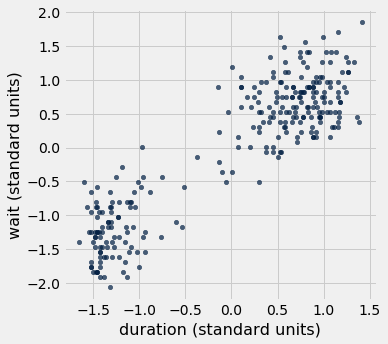

In [9]:
faithful_standard.scatter('duration (standard units)')

You'll notice that this plot looks exactly the same as the last one!  The data really are different, but the axes are scaled differently.  (The method `scatter` scales the axes so the data fill up the available space.)  So it's important to read the ticks on the axes.

** Question 1.4 **
Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

* -1
* 0
* 1

Assign your answer to `closest_correlation`.

In [10]:
closest_correlation = 1

In [11]:
grade('tests/q1_4.py')

** Question 1.5 **
<br/>
Compute the correlation `r`.  *Hint:* Use `faithful_standard`.  Section [15.1](https://www.inferentialthinking.com/chapters/15/1/correlation.html) explains how to do this.

In [12]:
r = np.mean(faithful_standard.column(0)*faithful_standard.column(1))
r

0.9008111683218132

## 2. Variability of the Sample Mean

By the Central Limit Theorem, the probability distribution of the mean of a large random sample is roughly normal. The bell curve is centered at the population mean. Some of the sample means are higher, and some lower, but the deviations from the population mean are roughly symmetric on either side, as we have seen repeatedly. Formally, probability theory shows that the sample mean is an unbiased estimate of the population mean.

In our simulations, we also noticed that the means of larger samples tend to be more tightly clustered around the population mean than means of smaller samples. In this section, we will quantify the variability of the sample mean and develop a relation between the variability and the sample size.

Let's take a look at the salaries of employees of the City of San Francisco in 2014. The mean salary reported by the city government was about $75463.92.

In [14]:
salaries = Table.read_table('sf_salaries_2014.csv').select("salary")
salaries

salary
471953
390112
339654
326717
326233
344187
311299
310161
335485
329391


In [15]:
salary_mean = np.mean(salaries.column('salary'))
salary_mean

75463.91814023031

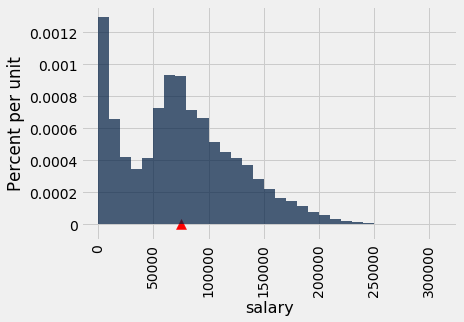

In [16]:
salaries.hist('salary', bins=np.arange(0, 300000+10000*2, 10000))
plots.scatter(salary_mean, 0, marker='^', color='red', s=100);

** Question 2.1 **
<br/>
Clearly, the population does not follow a normal distribution. Keep that in mind as we progress through these exercises.

Let's take random samples and look at the probability distribution of the sample mean. As usual, we will use simulation to get an empirical approximation to this distribution.

We will define a function `simulate_sample_mean` to do this, because we are going to vary the sample size later. The arguments are the name of the table, the label of the column containing the variable, the sample size, and the number of simulations.

Complete the function `simulate_sample_mean`. It will not be graded, but if you haven't implemented it correctly, the rest of the lab won't work properly, so this step is crucial.

In [19]:
"""Empirical distribution of random sample means"""

def simulate_sample_mean(table, label, sample_size, repetitions):
    
    means = []

    for i in np.arange(repetitions):
        new_sample = np.random.choice(table.column(label),sample_size)
        new_sample_mean = np.mean(new_sample)
        means = np.append(means,new_sample_mean)

    sample_means = Table().with_column('Sample Means', means)
    
    # Display empirical histogram and print all relevant quantities – don't change this!
    sample_means.hist(bins=20)
    plots.xlabel('Sample Means')
    plots.title('Sample Size ' + str(sample_size))
    print("Sample size: ", sample_size)
    print("Population mean:", np.mean(table.column(label)))
    print("Average of sample means: ", np.mean(means))
    print("Population SD:", np.std(table.column(label)))
    print("SD of sample means:", np.std(means))

** Question 2.2 **
<br/>
In the following cell, we will create a sample of size 100 from the salaries table and graph it using our new `simulate_sample_mean` function.

Sample size:  100
Population mean: 75463.91814023031
Average of sample means:  75490.68266159
Population SD: 51697.0349864653
SD of sample means: 5228.609821834311


(50000, 100000)

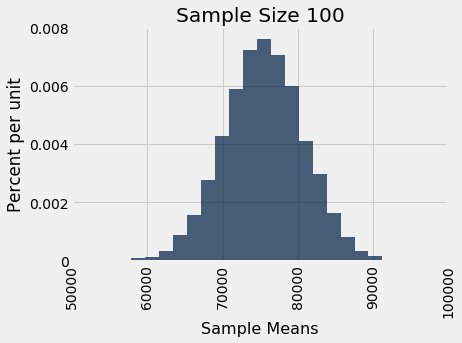

In [20]:
simulate_sample_mean(salaries, 'salary', 100, 10000) 
plots.xlim(50000, 100000)

In the following two cells, simulate the mean of a random sample of 400 salaries and 625 salaries, respectively. In each case, perform 10,000 repetitions of each of these processes. Don't worry about the `plots.xlim` line – it just makes sure that all of the plots have the same x-axis. 

Sample size:  400
Population mean: 75463.91814023031
Average of sample means:  75509.4600475425
Population SD: 51697.0349864653
SD of sample means: 2604.148721423265


(50000, 100000)

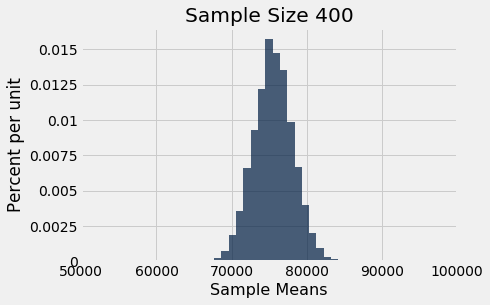

In [21]:
simulate_sample_mean(salaries, 'salary', 400, 10000)
plots.xlim(50000, 100000)

Sample size:  625
Population mean: 75463.91814023031
Average of sample means:  75479.4992837104
Population SD: 51697.0349864653
SD of sample means: 2074.345042996298


(50000, 100000)

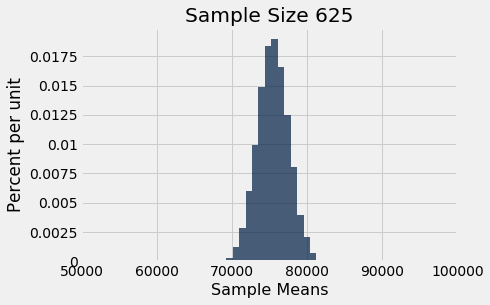

In [22]:
simulate_sample_mean(salaries, 'salary', 625, 10000)
plots.xlim(50000, 100000)

We can see the Central Limit Theorem in action – the histograms of the sample means are roughly normal, even though the histogram of the salaries themselves is far from normal.

We can also see that each of the three histograms of the sample means is centered very close to the population mean. In each case, the "average of sample means" is very close to the population mean. Both values are provided in the printout above each histogram. As expected, the sample mean is an unbiased estimate of the population mean.

** Question 2.3 **
<br/>
Below, we'll look at what happens when we take a fixed sample, then bootstrap from it with different numbers of resamples. How does the distribution of the resampled means change?

Sample size:  100
Population mean: 75463.91814023031
Average of sample means:  75629.580726
Population SD: 51697.0349864653
SD of sample means: 4995.549335415088


(50000, 100000)

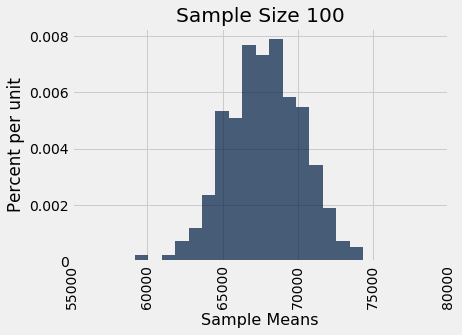

In [23]:
simulate_sample_mean(salaries, 'salary', 100, 1000)
plots.xlim(50000, 100000)

Sample size:  100
Population mean: 75463.91814023031
Average of sample means:  75370.67277456
Population SD: 51697.0349864653
SD of sample means: 5204.343079323123


(50000, 100000)

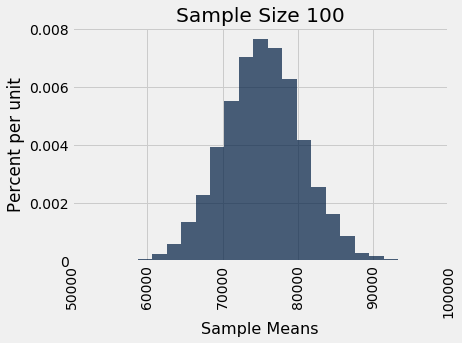

In [24]:
simulate_sample_mean(salaries, 'salary', 100, 5000)
plots.xlim(50000, 100000)

Sample size:  100
Population mean: 75463.91814023031
Average of sample means:  75481.57093909
Population SD: 51697.0349864653
SD of sample means: 5203.086253052809


(50000, 100000)

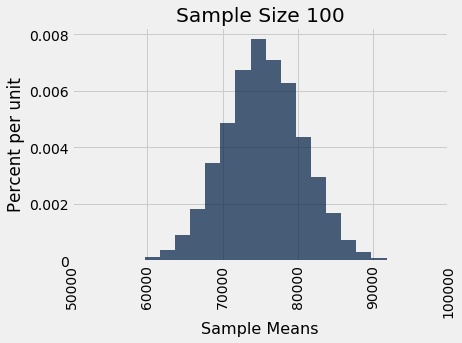

In [25]:
simulate_sample_mean(salaries, 'salary', 100, 10000)
plots.xlim(50000, 100000)

Assign the variable `bootstrap_sampled_SD` to the integer corresponding to your answer to the following question:

When I increase the number of bootstrap samples that I take, for a fixed sample size, the SD of my sample mean will...

1. Increase
2. Decrease
3. Stay about the same
4. Vary widly

In [29]:
bootstrap_sampled_SD = 3

Sample size:  100
Population mean: 75463.91814023031
Average of sample means:  75370.15880159999
Population SD: 51697.0349864653
SD of sample means: 5166.063366751442


(50000, 100000)

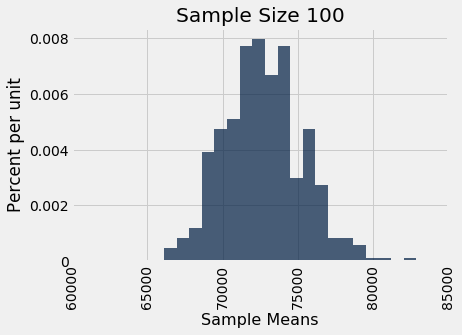

In [31]:
simulate_sample_mean(salaries, 'salary', 100, 500)
plots.xlim(50000, 100000)

** Question 2.4 **
<br/>
Next, let's think about how the relationships between population SD, sample SD, and SD of sample means change with varying sample size. Which of the following is true? Again, assign the variable `pop_vs_sample` to the integer corresponding to your answer. To gain some intuition, you can run the simulation cells below.

1. Sample SD gets smaller with increasing sample size, SD of sample means gets smaller with increasing sample size
2. Sample SD gets larger with increasing sample size, SD of sample means stays the same with increasing sample size
3. Sample SD becomes more consistent with population SD with increasing sample size, SD of sample means gets smaller with increasing sample size
4. Sample SD becomes more consistent with populatoin SD with increasing sample size, SD of smaple means stays the same with increasing sample size

In [32]:
pop_vs_sample = 3

Let's see what happens: First, we calculate the population SD so that we can compare the SD of each sample to the SD of the population.

In [34]:
pop_sd = np.std(salaries.column("salary"))
pop_sd

51697.0349864653

Let's then how a small sample behaves. Run the following cells multiple times to see how the SD of the sample changes from sample to sample. Adjust the bins as necessary.

Sample SD:  44119.73716315274
Sample size:  10
Population mean: 84579.677
Average of sample means:  84112.467382
Population SD: 44119.73716315274
SD of sample means: 13975.507778304596


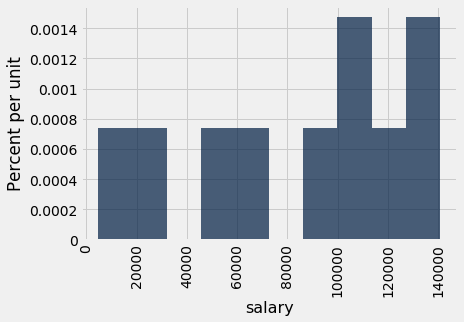

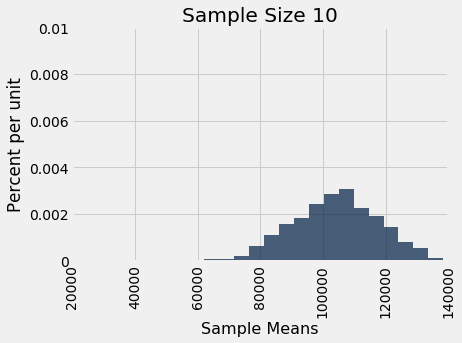

In [37]:
sample_10 = salaries.sample(10)
sample_10.hist("salary")
print("Sample SD: ", np.std(sample_10.column("salary")))
simulate_sample_mean(sample_10, 'salary', 10, 1000)
plots.xlim(5,120000)
plots.ylim(0, .0001);

Sample SD:  49312.1363698964
Sample size:  200
Population mean: 67917.9569
Average of sample means:  67895.59656529999
Population SD: 49312.1363698964
SD of sample means: 3528.1430448271526


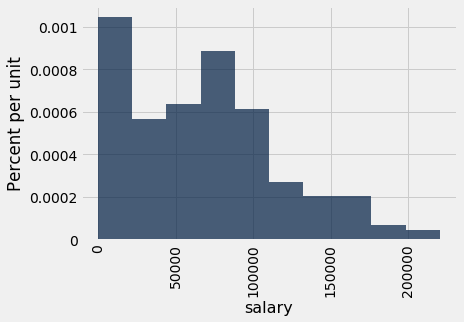

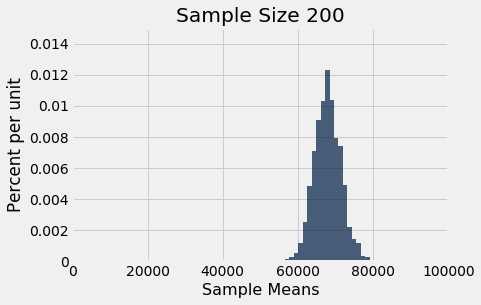

In [39]:
sample_200 = salaries.sample(200)
sample_200.hist("salary")
print("Sample SD: ", np.std(sample_200.column("salary")))
simulate_sample_mean(sample_200, 'salary', 200, 1000)
plots.xlim(5,100000)
plots.ylim(0, .00015);

Sample SD:  49780.61615481119
Sample size:  1000
Population mean: 75362.66468
Average of sample means:  75372.88110199
Population SD: 49780.61615481119
SD of sample means: 1600.947506533103


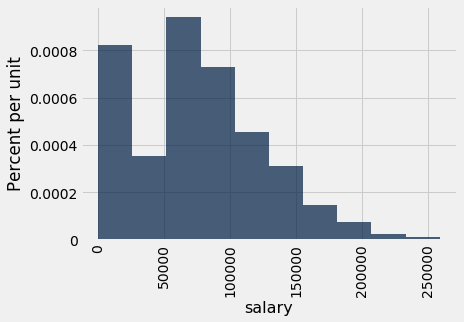

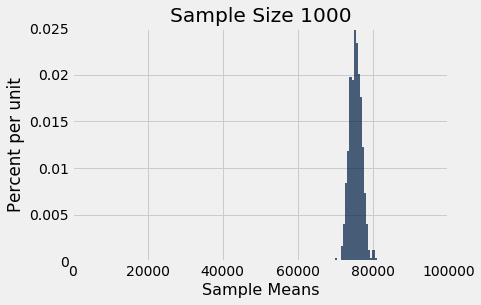

In [41]:
sample_1000 = salaries.sample(1000)
sample_1000.hist("salary")
print("Sample SD: ", np.std(sample_1000.column("salary")))
simulate_sample_mean(sample_1000, 'salary', 1000, 1000)
plots.xlim(5,100000)
plots.ylim(0, .00025);

Let's illustrate this trend. Below, you will see how the average absolute error of SD from the population changes with sample size (N).

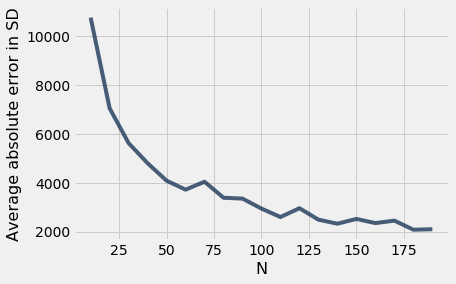

In [42]:
# Don't change this cell, just run it!
sample_n_errors = make_array()
for i in np.arange(10, 200, 10):
    sample_n_errors = np.append(sample_n_errors, np.average([abs(np.std(salaries.sample(i).column("salary"))-pop_sd)
                                                             for d in np.arange(100)]))
Table().with_column("Average absolute error in SD", sample_n_errors, "N", np.arange(10, 200, 10)).plot("N", "Average absolute error in SD")

You should notice that the distribution of means gets spiker, and that the distribution of the sample increasingly looks like the distribution of the population as we get to larger sample sizes. 

Is there a relationship between the sample size and absolute error in standard deviation? Identify this relationship – if you're having trouble, take a look at [Section 14.5](https://www.inferentialthinking.com/chapters/14/5/Variability_of_the_Sample_Mean) in our textbook.

## Submission

You're finished with lab 1! In order to successfully submit your assignment, follow these steps...
- **IMPORTANT** Before you do anything, **Save and Checkpoint** from the `File` menu. Please do this first before running the cell below,
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook** If you make any changes, please **Save and Checkpoint** again.